In [1]:
import numpy as np
from numpy import asarray

from PIL import Image

import os

import pandas as pd

import keras
from keras.layers import Dense, Softmax, Conv2D, Input, MaxPooling2D, Flatten, RandomContrast
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skimage.transform import resize
from sklearn.metrics import accuracy_score, classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, KFold
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader

from joblib import dump

from matplotlib import pyplot as plt

/Users/jezza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load the data

In [2]:
'''

CREATE THE .NPZ FILE

'''
# folder_path = './data/MixedTrainingNumpy/'

# data = {}

# for file in os.listdir(folder_path):
#     if file.endswith('.npy'):

#         file_path = os.path.join(folder_path, file)
#         array = np.load(file_path)

#         label = file[0]

#         data[label] = array

# np.savez('./data/Training.npz', **data)

'\n\nCREATE THE .NPZ FILE\n\n'

In [3]:
'''

LOADS AND "FORMALISES" DATA SO CAN BE PASSED INTO PREPROCESSING

'''

def loadData(filePath):
    images = []
    labels = []

    for filename in os.listdir(filePath):
        if filename.endswith('.npy'):

            img = np.load(os.path.join(filePath, filename))

            img = resize(img, (128, 128), anti_aliasing=True) # TODO - NOT NORMALISING DIDN'T YIELDED THE SAME VALUES

            # display_img = np.clip(img * 255, 0, 255).astype('uint8')
            # plt.imshow(display_img)
            # plt.show()
            
            images.append(img)
            
            label = filename[0]
            labels.append(label)

    imagesNP = np.array(images)
    labelsNP = np.array(labels)

    # Adjust this if your labels are not numeric
    encoder = LabelEncoder()
    intLabels = encoder.fit_transform(labelsNP)
    intLabels = to_categorical(intLabels)

    # Split the data into training and validation sets
    return imagesNP, intLabels, encoder

In [4]:
def featureExtractionModel():
    model = Sequential()
    model.add(Input(shape=(128,128,3))) # Images are 100 by 100 and RGB

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))#Break the image into separate sub-image
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())

    # Softmax Regression
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    return model

Done


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
(2289, 28800)
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
(573, 28800)
   Actual:   Pred: 
0       179     127
1        69      84
2       175     177
3       150     185
Predicted: 3, Actual: [0. 0. 0. 1.]


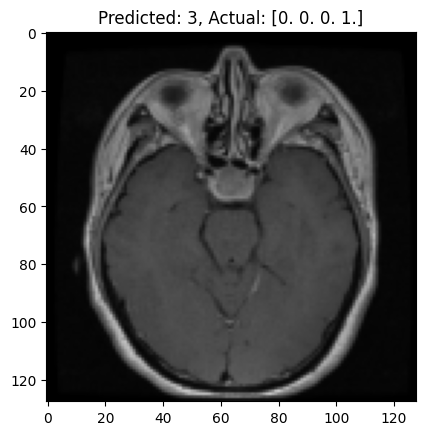

Predicted: 1, Actual: [0. 0. 1. 0.]


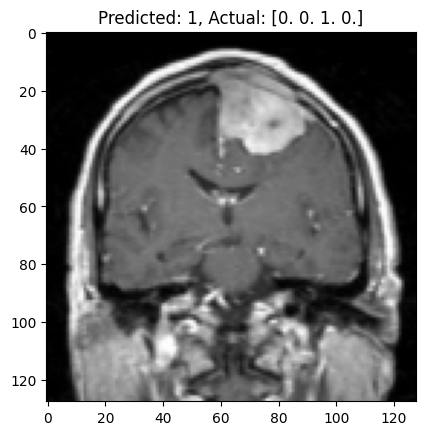

Predicted: 3, Actual: [0. 0. 0. 1.]


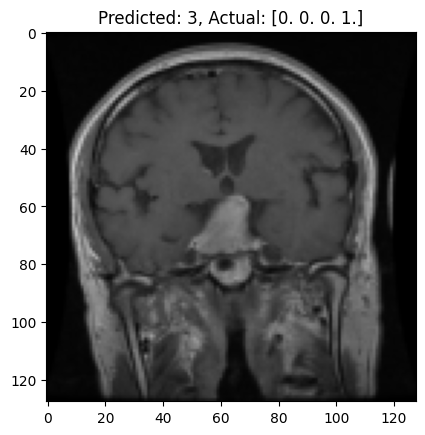

Predicted: 0, Actual: [1. 0. 0. 0.]


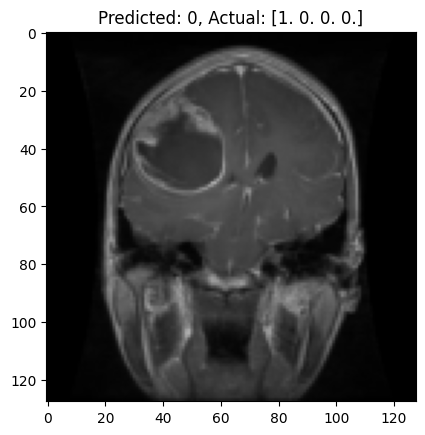

Predicted: 3, Actual: [1. 0. 0. 0.]


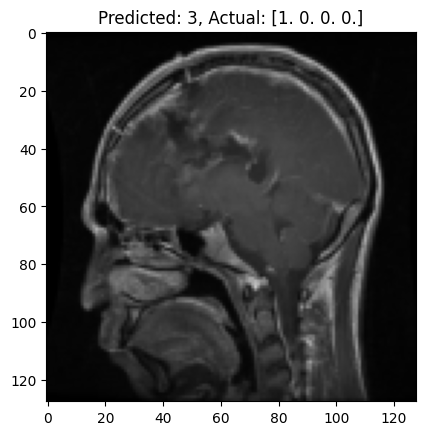

Random Forest Classifier Accuracy: 79.40663176265271%


In [8]:
def main():
    filePath = './data/MixedTrainingNumpy/'
    imagesNP, labelsNP, encoder = loadData(filePath)
    print("Done")

    imTrain, imTest, labTrain, labTest = train_test_split(imagesNP, labelsNP, test_size=0.2, random_state=42)

    # kFold = KFold(n_splits=5, shuffle=True, random_state=42)

    # foldN = 1
    # bestLoss = 10

    # for train, test in kFold.split(imTrain, labTrain):
    #     model = featureExtractionModel()

    #     #optimiser = keras.optimizers.Adam(learning_rate=0.001)
    #     model.compile(loss='categorical_crossentropy', metrics=['AUC', 'accuracy'])

    #     print(f'Training for fold {foldN}...')
    #     model.fit(imTrain[train], labTrain[train], epochs=15, batch_size=4, validation_data=(imTrain[test], labTrain[test]))

    #     foldN += 1
    #     score = model.evaluate(imTrain[test], labTrain[test], verbose=0)
    #     print(f'Score for fold {foldN}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

    #     if score[0] < bestLoss:
    #         bestLoss = score[0]
    #         bestModel = model

    # bestModel.save("./CNN.h5")


    # test_score = model.evaluate(imTest, labTest, verbose=0)
    # print(f'Test Score: Loss = {test_score[0]}; AUC = {test_score[1]*100}%; Accuracy = {test_score[2]*100}%')


    model = load_model("./CNN.h5")

    featureModel = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

    featureTrain = featureModel.predict(imTrain)
    print(featureTrain.shape)
    featureTest = featureModel.predict(imTest)
    print(featureTest.shape)
    


    randForestDist = { # Grid search takes too long so use Halving Random Search
        'n_estimators' : sp_randint(500, 1000),
        'criterion' : ['gini', 'entropy', 'log_loss'],
        'max_depth' : [10, 20, 30, None],
        'min_samples_split' : sp_randint(2, 10),
        'min_samples_leaf' : sp_randint(1, 8),
        'max_features' : ['log2', 'sqrt', None],
        'bootstrap' : [True, False],
        'warm_start' : [True, False],
        'class_weight' : ['balance_subsample', None],
        #'ccp_alpha' : sp_randint(0, 0.025)
    }

    #CRAP ==> {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 924, 'warm_start': False} Random Forest Classifier Accuracy: 90.75043630017451%
    #n_estimators=1000, random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, bootstrap=False
    randForest = RandomForestClassifier(n_estimators=1000, random_state=45, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, bootstrap=False, ccp_alpha=0.01)
    #forestGridSearch = HalvingRandomSearchCV(estimator=randForest, param_distributions=randForestDist, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    #forestGridSearch.fit(featureTrain, np.argmax(labTrain, axis=1))
    #print("Best parameters found: ", forestGridSearch.best_params_)
    randForest.fit(featureTrain, np.argmax(labTrain, axis=1))

    #optimalRandForest = forestGridSearch.best_estimator_

    rfPred = randForest.predict(featureTest)

    # rfPredRAW = encoder.inverse_transform([np.argmax(label) for label in rfPred])
    # realLabelRAW = encoder.inverse_transform([np.argmax(label) for label in labTest])

    countReal = pd.Series(np.argmax(labTest, axis=1)).value_counts()
    countPred = pd.Series(rfPred).value_counts()

    compareCount = pd.DataFrame({'Actual: ': countReal, 'Pred: ': countPred})
    print(compareCount)

    for i in range(min(5, len(rfPred))):
        print(f'Predicted: {rfPred[i]}, Actual: {labTest[i]}')
        plt.imshow(imTest[i])
        plt.title(f'Predicted: {rfPred[i]}, Actual: {labTest[i]}')
        plt.show()

    accuracy = accuracy_score(np.argmax(labTest, axis=1), rfPred)
    print(f'Random Forest Classifier Accuracy: {accuracy * 100}%')

    #TODO - DO CROSS VALIDATION ON RAND FOREST



    '''
    # hyperparamGrid = {
    #     'n_neighbors' : [2, 4, 8],
    #     'algorithm' : ['ball_tree', 'brute'],
    #     'leaf_size' : [20, 30, 50],
    #     'p' : [1, 2, 3],
    #     #'metric' : ['auto', 'sqrt']
    # }

    knnModel = KNeighborsClassifier(n_neighbors=4, weights='distance', leaf_size=4)

    #hyperparamSearch = GridSearchCV(estimator=knnModel, param_grid=hyperparamGrid, cv=3, n_jobs=-1, verbose=2, return_train_score=True)

    knnModel.fit(featureTrain, np.argmax(labTrain, axis=1))
    #hyperparamSearch.fit(featureTrain, np.argmax(labTrain, axis=1))

    #print("Optimal hyperparameters: ", hyperparamSearch.best_params_)

    knnPred = knnModel.predict(featureTest)

    knnAccuracy = accuracy_score(np.argmax(labTest, axis=1), knnPred)
    print(f'KNN Classifier Accuracy: {knnAccuracy * 100}%')
    '''

main()